# Olist : maintenance

In [105]:
#librairies import

import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

from scipy.stats import kstest, norm, expon, uniform

We will first use the ks test to evaluate if our data follows a certain logic

import train_test_split \
split dataset \
X = données actuelles \
y = données futures \
Train sur X \
y => tester l'évolution => ARI

In [ ]:
'''data = pd.read_csv('data/olist_customers_whole.csv')
data.head()'''

In [95]:
data = pd.read_csv('data/data_with_clustering.csv')
data.head()

,last_purchase,days_since_last_purchase,total_price_items,km_cluster,total_freight_value,total_orders,km_enriched_cluster,DBSCAN_cluster
0,1.534792e+09,2129,729.62,0,172.42,17,4,-1
1,1.519757e+09,2303,1000.85,3,171.82,9,4,-1
2,1.530147e+09,2182,664.20,0,94.63,7,4,-1
3,1.527853e+09,2209,806.61,0,316.11,7,4,-1
4,1.518615e+09,2316,855.21,3,165.91,7,4,-1


In [ ]:
'''#Model import

joblib_file = "kmeans_model.pkl"
kmeans_original = joblib.load(joblib_file)'''

### ARI analysis

In [ ]:
#drop clustering
data = data.drop(columns = ['km_enriched_cluster', 'DBSCAN_cluster', 'km_cluster'])
data.head()

Need to translate last_purchase in datetime again \
Will also need to duplicate a datetime column to be droped, so as to select correct time but not be blocked for StandardScaler \
So will translate directly on new column

In [97]:
data['date_reference'] = pd.to_datetime(data['last_purchase'], unit='s')
data.head()

,last_purchase,days_since_last_purchase,total_price_items,total_freight_value,total_orders,date_reference
0,1.534792e+09,2129,729.62,172.42,17,2018-08-20 19:14:26
1,1.519757e+09,2303,1000.85,171.82,9,2018-02-27 18:36:39
2,1.530147e+09,2182,664.20,94.63,7,2018-06-28 00:43:34
3,1.527853e+09,2209,806.61,316.11,7,2018-06-01 11:38:29
4,1.518615e+09,2316,855.21,165.91,7,2018-02-14 13:22:12


In [108]:
#set init over a month
period_start = pd.to_datetime('2017-01-01')
period_end = pd.to_datetime('2017-02-01')
mask_F0 = (data['date_reference'] > period_start) & (
    data['date_reference'] <= period_end)
data_init = data.loc[mask_F0].drop(columns='date_reference')

In [80]:
#importing pipeline from clustering notebook
#Pipeline scaling+training
def train_kmeans(data, scaler, best_k):
    pipeline = Pipeline([
    ('scaler', scaler),
    ('kmeans', KMeans(n_clusters=best_k, random_state=42, n_init=10, init='k-means++'))
])
    return pipeline.fit(data)

In [109]:
data_init.head()

,last_purchase,days_since_last_purchase,total_price_items,total_freight_value,total_orders
5,1.483630e+09,2721,58.40,52.32,6
39,1.483625e+09,2721,38.60,34.88,4
140,1.485437e+09,2700,269.22,81.75,3
161,1.483624e+09,2721,30.70,26.16,3
176,1.483618e+09,2721,20.70,26.16,3


In [ ]:
#fit data 
kmeans_init = train_kmeans(data_init, StandardScaler(), 4)

#clustering labels
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [114]:
#init empty ari score
ari_score_month = []

#loop on each month
for p in range(1, 12):
    # Création des datasets par périodes
    start_date = pd.to_datetime('2017-01-01')
    start_T0 = pd.to_datetime('2018-01-01')
    start_date_Tp = start_T0 + relativedelta(months=p)  # Incrémentation de 1 mois
    data_period = data.copy()
    mask_data_period = (data['date_reference'] > start_date) & (
        data['date_reference'] <= start_date_Tp)
    data_period = data.loc[mask_data_period].drop(
        columns='date_reference')

    # K-Means
    kmeans_p = train_kmeans(data_period, StandardScaler(), 4)   
    p_labels = kmeans_p.named_steps['kmeans'].labels_

    # Calcul des ARI score
    ari_p = adjusted_rand_score(kmeans_init.predict(
        data_period), kmeans_p.predict(data_period))
    ari_score_month.append([p, ari_p])

print(ari_score_month)

[[1, 0.030522477045932823], [2, 0.02887626745968392], [3, 0.027374789184944452], [4, 0.026744343652586215], [5, 0.025768001648417412], [6, 0.024983164312105524], [7, 0.02416430051042637], [8, 0.01914886970076701], [9, 0.01913986565587539], [10, 0.019204300271262305], [11, 0.019204300271262305]]


The first month is the same and is used as a checker. Just by the second month, differences are about 70%

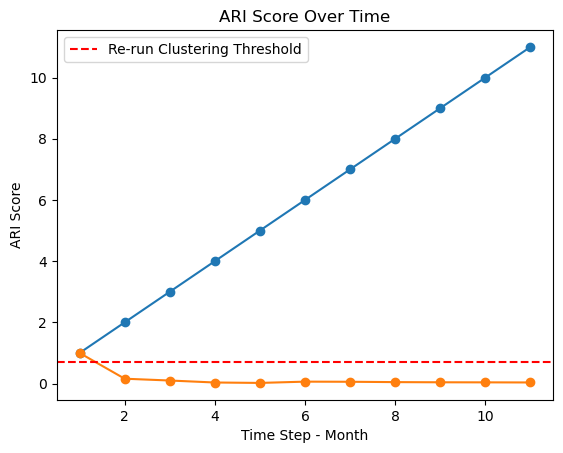

In [116]:
#plot ARI evolution per month
plt.plot(range(1, 12), ari_score_month, marker='o')
plt.xlabel('Time Step - Month')
plt.ylabel('ARI Score')
plt.title('ARI Score Over Time')
plt.axhline(y=0.7, color='r', linestyle='--', label='Re-run Clustering Threshold')
plt.legend()
plt.show()

In [118]:
#init empty ari score
ari_score_weeks = []

#loop on each month
for p in range(1, 52):
    # Création des datasets par périodes
    start_date = pd.to_datetime('2017-01-01')
    start_T0 = pd.to_datetime('2018-01-01')
    start_date_Tp = start_T0 + relativedelta(days=+7*p)  # Incrémentation de 1 semaine
    data_period = data.copy()
    mask_data_period = (data['date_reference'] > start_date) & (
        data['date_reference'] <= start_date_Tp)
    data_period = data.loc[mask_data_period].drop(
        columns='date_reference')

    # K-Means
    kmeans_p = train_kmeans(data_period, StandardScaler(), 4)   
    p_labels = kmeans_p.named_steps['kmeans'].labels_

    # Calcul des ARI score
    ari_p = adjusted_rand_score(kmeans_init.predict(
        data_period), kmeans_p.predict(data_period))
    ari_score_weeks.append([p, ari_p])

print(ari_score_weeks)

[[1, 0.032737156699309045], [2, 0.03190983958401319], [3, 0.031490886261508845], [4, 0.030640138586527834], [5, 0.030235507637695086], [6, 0.029593497075389302], [7, 0.0293652247146291], [8, 0.029044200899198323], [9, 0.028585131796896476], [10, 0.028519542929389564], [11, 0.02813222353537782], [12, 0.027613234637607776], [13, 0.027428548358012637], [14, 0.027224331528782137], [15, 0.027194782751771014], [16, 0.02692318332698376], [17, 0.026899959149014066], [18, 0.02652395456297211], [19, 0.026396895894845663], [20, 0.026072674083363896], [21, 0.025945323290362206], [22, 0.02578557428180392], [23, 0.025601192963239514], [24, 0.025341815471253738], [25, 0.02507403062160267], [26, 0.02501859888574031], [27, 0.024785662095797897], [28, 0.024792141362602535], [29, 0.024601875224142766], [30, 0.024269918811386928], [31, 0.02364910126070799], [32, 0.01973773073059024], [33, 0.019417227070045753], [34, 0.019170226379388908], [35, 0.01914886970076701], [36, 0.019144717307127735], [37, 0.01914

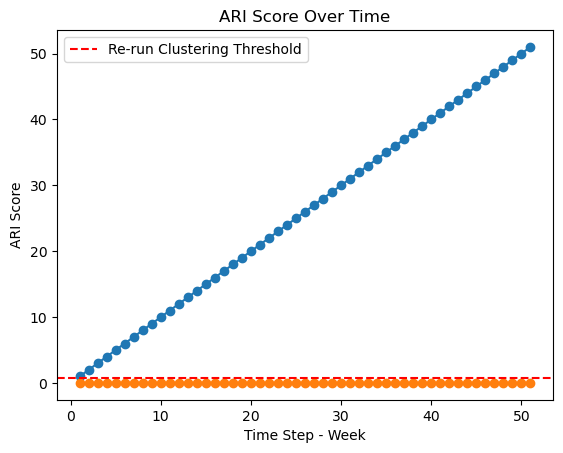

In [120]:
#plot ARI evolution per week
plt.plot(range(1, 52), ari_score_weeks, marker='o')
plt.xlabel('Time Step - Week')
plt.ylabel('ARI Score')
plt.title('ARI Score Over Time')
plt.axhline(y=0.7, color='r', linestyle='--', label='Re-run Clustering Threshold')
plt.legend()
plt.show()